# Image registration of an EBSD data set to a BSE image

Håkon Wiik Ånes (hakon.w.anes@ntnu.no), 2022-11-29, Norwegian University of Science and Technology (NTNU)

In [1]:
# Use the qt5 backend for interactive plotting (from the pyqt package)
%matplotlib inline

from datetime import date
import importlib_metadata
import os

from dask.diagnostics import ProgressBar
import dask
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import morphops
import numpy as np
from orix import io as oio
from orix.crystal_map import CrystalMap
from orix.quaternion import Rotation
import skimage.color as skc
import skimage.exposure as ske
import skimage.transform as skt
import skimage.util as sku
from tqdm import trange, tqdm


# Directories for input and output
sample = "175c"
dset_no = 1
dir_data = f"/home/hakon/phd/data/p/prover/{sample}"
dir_sample = os.path.join(dir_data, str(dset_no))
dir_bse = os.path.join(dir_sample, "bse")
dir_kp = os.path.join(dir_sample, "kp")
dir_imreg = os.path.join(dir_sample, "imreg")
dir_partdet = os.path.join(dir_sample, "partdet")

# Data set specific parameters
out_shapes = {
    "0s": {1: (800, 800), 2: (1400, 1400), 3: (1100, 1000)},
    "175c": {1: (950, 950), 2: (1100, 1100), 3: (1050, 1000)},
    "300c": {1: (1000, 1000), 2: (900, 820), 3: (1050, 950)},
    "325c": {1: (950, 950), 2: (850, 750), 3: (1100, 1100)}
}
cp_plot_pad = {
    "0s": {1: (50, 50), 2: (75, 50), 3: (150, 50)},
    "175c": {1: (50, 50), 2: (50, 50), 3: (150, 50)},
    "300c": {1: (50, 50), 2: (150, 50), 3: (150, 50)},
    "325c": {1: (150, 50), 2: (150, 50), 3: (100, 50)},
}

# Matplotlib configuration and keyword arguments
plt.rcParams.update({"font.size": 12})
savefig_kw = dict(bbox_inches="tight", pad_inches=0, transparent=True, dpi=150)
scatter_kw = dict(s=70, linewidth=2, facecolor="none", clip_on=False)
#plt.ioff()

print(sample, dset_no)
print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in [
    "dask",
    "matplotlib",
    "morphops",
    "numpy",
    "orix",
    "scikit-image",
    "tqdm"
]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

175c 1
Run date:  2022-11-29

Software versions
-----------------
dask : 2022.11.1
matplotlib : 3.6.2
morphops : 0.1.13
numpy : 1.23.5
orix : 0.10.2
scikit-image : 0.19.3
tqdm : 4.64.1


Step sizes

In [2]:
step_size = dict(ebsd=100, bse=1 / 39.2e-3)

New BSE scale so that the particle map produced from the upscaled BSE image can be binned by an integer factor

In [3]:
scale_ebsd_bse = step_size["ebsd"] / step_size["bse"]
scale_bse_ebsd = step_size["bse"] / step_size["ebsd"]

x_bin = int(np.ceil(scale_ebsd_bse))
upscale_factor = x_bin * scale_bse_ebsd

## 1. Manually identify control points

EBSD map (sensed image)

In [4]:
ebsd = plt.imread(os.path.join(dir_kp, "maps_mean_q1_q99.png"))
if len(ebsd.shape) > 2:
    ebsd = skc.rgb2gray(ebsd[..., :3])

# Alternative map of normalized cross-correlation (NCC) scores after orientation refinement
# to find control points in. These maps usually show a good grain/phase boundary contrast.
#ebsd = plt.imread(os.path.join(dir_kp, "maps_ncc_ref.png"))

BSE image (reference image)

In [5]:
bse = plt.imread(os.path.join(dir_bse, "4500x_cropped2_fused_cropped_cropped.png"))
if bse.ndim > 2:
    bse = skc.rgb2gray(bse[..., :3])

Identify coordinates (x, y) and (X, Y) of corresponding control points and write
them to a text file

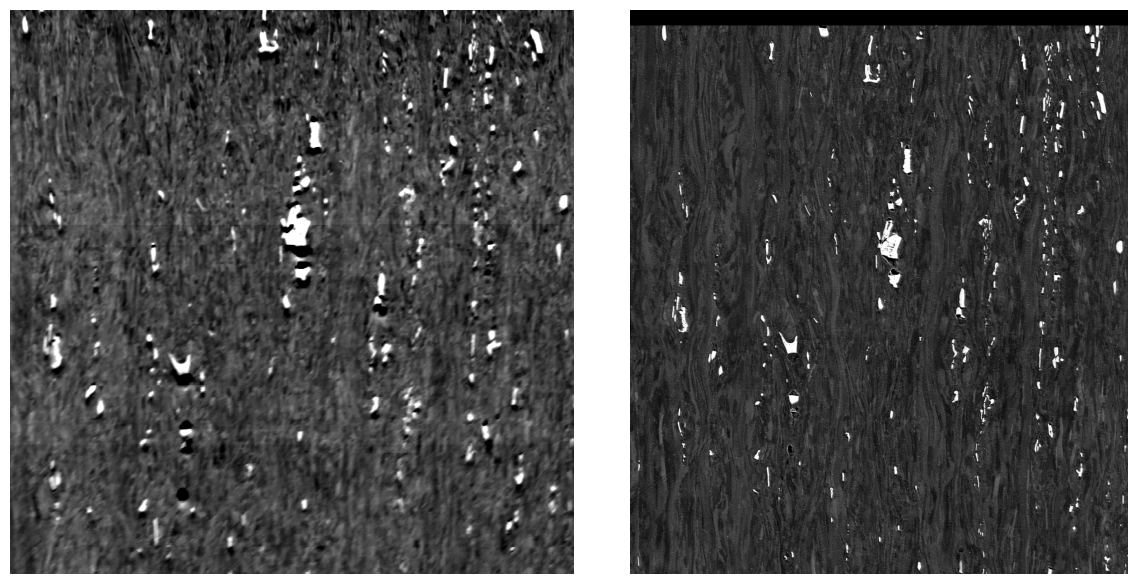

In [24]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))
ax0.imshow(ebsd, cmap="gray")
ax1.imshow(bse, cmap="gray")
ax0.axis("off")
ax1.axis("off")
fig.tight_layout()

Load identified control points

In [10]:
cpx_ebsd, cpy_ebsd, cpx_bse, cpy_bse = np.loadtxt(
    os.path.join(dir_imreg, f"cps_{sample}_{dset_no}_cropped2_fused_cropped_cropped.csv"),
    skiprows=1,
    delimiter=",",
    unpack=True,
)
cp_ebsd = np.column_stack([cpy_ebsd, cpx_ebsd])
cp_bse = np.column_stack([cpy_bse, cpx_bse])

# Scale BSE CPs to maintain EBSD resolution
cp_bse_scaled = cp_bse / scale_ebsd_bse

# Translate BSE CPs
cp_bse_translated = cp_bse_scaled - (cp_bse_scaled.mean(axis=0) - cp_ebsd.mean(axis=0))

Adjust CPs (e.g. when changing the padding of the cropped/fused/cropped BSE image)

In [ ]:
#np.savetxt(
#    os.path.join(dir_imreg, f"cps_{sample}_{dset_no}_cropped2_fused_cropped_cropped.csv"),
#    X=np.column_stack([cpx_ebsd, cpy_ebsd, cpx_bse, cpy_bse + 100]),
#    delimiter=",",
#    fmt="%i"
#)

Plot control points on images

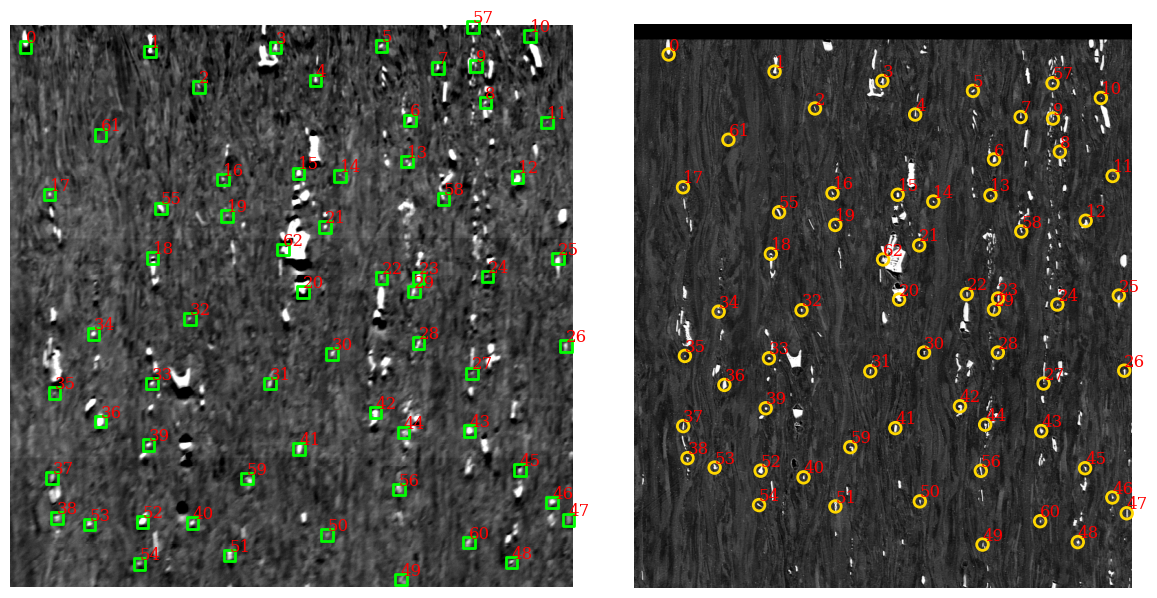

In [23]:
markers = ["s", "o"]
marker_colors = ["lime", "gold"]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))
ax0.imshow(ebsd, cmap="gray")
ax1.imshow(bse, cmap="gray")
for i, (y, x) in enumerate(cp_ebsd):
    ax0.scatter(x, y, marker=markers[0], color=marker_colors[0], **scatter_kw)
    ax0.text(x, y, str(i), c="r", ha="left", va="bottom")
for i, (y, x) in enumerate(cp_bse):
    ax1.scatter(x, y, marker=markers[1], color=marker_colors[1], **scatter_kw)
    ax1.text(x, y, str(i), c="r", ha="left", va="bottom")
ax0.axis("off")
ax1.axis("off")
fig.tight_layout()
fig.savefig(os.path.join(dir_imreg, "images_control_points.png"), **savefig_kw)

Plot control points on images with relative shifts

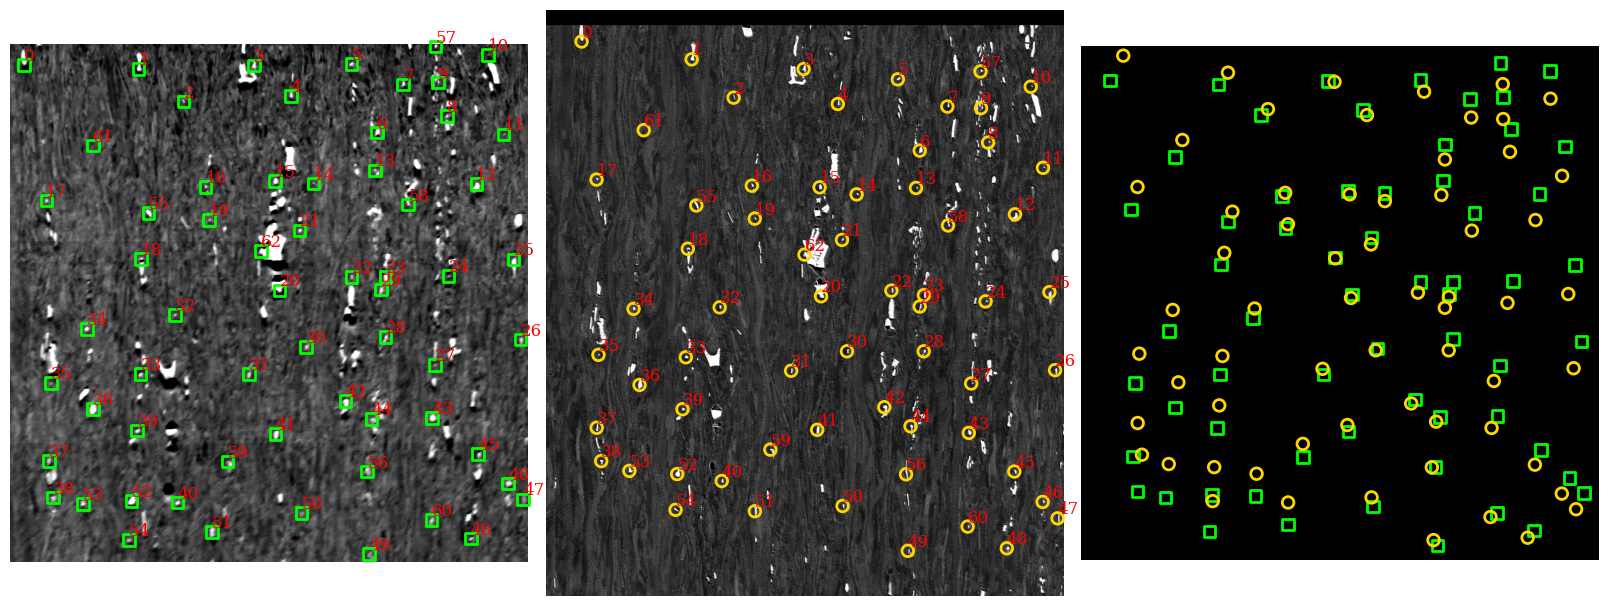

In [12]:
# Keyword arguments shared among Matplotlib calls
imshow_kwds = dict(cmap="gray", interpolation=None)

figsize = (18 * bse.shape[1] / max(bse.shape), 6 * bse.shape[0] / max(bse.shape))
fig, axes = plt.subplots(ncols=3, figsize=figsize)
ax0, ax1, ax2 = axes
ax0.imshow(ebsd, **imshow_kwds)
ax1.imshow(bse, **imshow_kwds)
# Shape of figure of relative positions between CPs
pad = cp_plot_pad[sample][dset_no]
nr, nc = tuple(np.max(np.concatenate((cp_bse_translated, cp_ebsd)), axis=0).astype(int) + np.array(pad))
ax2.imshow(np.zeros((nr, nc)), cmap="gray")

# Control points
for i, (y, x) in enumerate(cp_ebsd):
    ax0.scatter(x, y, marker=markers[0], color=marker_colors[0], **scatter_kw)
    ax0.text(x, y, str(i), c="r", ha="left", va="bottom")
for i, (y, x) in enumerate(cp_bse):
    ax1.scatter(x, y, marker=markers[1], color=marker_colors[1], **scatter_kw)
    ax1.text(x, y, str(i), c="r", ha="left", va="bottom")
for i, these_points in enumerate([cp_ebsd, cp_bse_translated]):
    for r, c in these_points:
        ax2.scatter(
            c + pad[1] / 2,
            r + pad[0] / 2,
            color=marker_colors[i],
            marker=markers[i],
            **scatter_kw
        )
for ax in axes:
    ax.axis("off")
fig.tight_layout(pad=0)
fig.savefig(os.path.join(dir_imreg, "images_control_points_shift.png"), **savefig_kw)

## 2. Correct source image using the thin plate spline transformation function

Get inverse map (input coordinates in the output image) using `morphops`. We use `dask` to wrap calls to `morphops` to keep memory use low.

In [13]:
# Output shape of corrected EBSD map
out_shape = out_shapes[sample][dset_no]
out_size = int(np.prod(out_shape))

# 2D indices (flattened) for each point in the output map
rc_out = np.indices(out_shape, dtype=float).reshape((2, -1)).T

# Obtain inverse mapping one chunk at a time to reduce memory use. This is done
# by first accumulating a list of delayed computations...
delayed_list = []
n_chunks = 100
chunk_size = int(np.ceil(out_size / n_chunks))
for idx in range(0, n_chunks * chunk_size, chunk_size):
    rc_chunk = rc_out[idx:idx + chunk_size]
    rc_in_part = dask.delayed(morphops.tps_warp)(X=cp_bse_scaled, Y=cp_ebsd, pts=rc_chunk)
    delayed_list.append(rc_in_part)

# ... and then computing the inverse mappings
with ProgressBar():
    rc_in_parts = dask.compute(*delayed_list)
rc_in = np.row_stack(rc_in_parts)

[########################################] | 100% Completed | 1.81 sms


Check coordinate shifts (should be smooth)

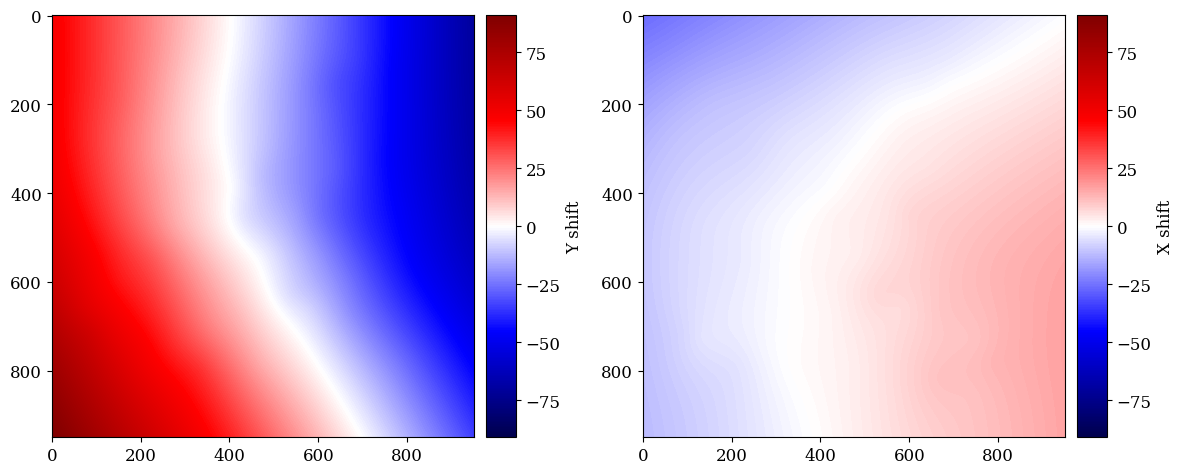

In [25]:
rc_shift = rc_in - rc_out
rc_center = rc_shift - rc_shift.mean(axis=0)

labels = ("Y shift", "X shift")
v_extent = max(abs(rc_center.min()), abs(rc_center.max()))
imshow_kwds = dict(vmin=-v_extent, vmax=v_extent, cmap="seismic")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i, a in enumerate(ax):
    im = a.imshow(rc_center[:, i].reshape(out_shape), **imshow_kwds)
    ax_divider = make_axes_locatable(a)
    fig.colorbar(im, cax=ax_divider.append_axes("right", size="7%", pad="3%"), label=labels[i])
fig.tight_layout()
fig.savefig(os.path.join(dir_imreg, "rc_shift.png"), **savefig_kw)

In [26]:
def get_mapping_arrays(rc_in, in_shape, out_shape):
    """Get 1D indices of corresponding points in input and output
    arrays.
    
    Parameters
    ----------
    rc_in : numpy.ndarray
    in_shape : tuple
    out_shape : tuple
    
    Returns
    -------
    rc_in_1d : numpy.ndarray
    rc_in_2d : tuple of numpy.ndarray
    rc_out_1d : numpy.ndarray
    rc_out_2d : tuple of numpy.ndarray
    """
    # Round exact input coordinates to nearest neighbour coordinates
    rc_in_int = np.round(rc_in).astype(int)

    # Set up output coordinate array
    rc_out = np.indices(out_shape).reshape((2, -1)).T
    
    # Remove coordinates outside input map in both arrays
    is_outside = np.logical_or((rc_in_int < 0).any(axis=1), (rc_in_int >= np.array(in_shape)).any(axis=1))
    is_outside_idx = np.where(is_outside)[0]
    rc_in_int = np.delete(rc_in_int, is_outside_idx, axis=0)
    rc_out = np.delete(rc_out, is_outside_idx, axis=0)
    
    # Get 1D indices
    rc_in_1d = np.ravel_multi_index(rc_in_int.T, in_shape)
    rc_out_1d = np.ravel_multi_index(rc_out.T, out_shape)

    # 2D coordinate arrays
    rc_in_2d = np.unravel_index(rc_in_1d, in_shape)
    rc_out_2d = np.unravel_index(rc_out_1d, out_shape)
    
    return rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d


def map_in_image(in_image, out_shape, rc_in_2d, rc_out_2d):
    """Map sensed (in) image from sensed coordinates to
    reference coordinates.
    
    Parameters
    ----------
    in_image : numpy.ndarray
    out_shape : tuple
    rc_in_2d : tuple of numpy.ndarray
    rc_out_2d : tuple of numpy.ndarray
    
    Returns
    -------
    out_image : numpy.ndarray
    """
    out_image = np.zeros(out_shape, dtype=in_image.dtype)
    out_image[rc_out_2d] = in_image[rc_in_2d]
    return out_image

In [27]:
rc_in_1d, rc_in_2d, rc_out_1d, rc_out_2d = get_mapping_arrays(
    rc_in=rc_in, in_shape=ebsd.shape, out_shape=out_shape
)

Check mapping of EBSD intensity map

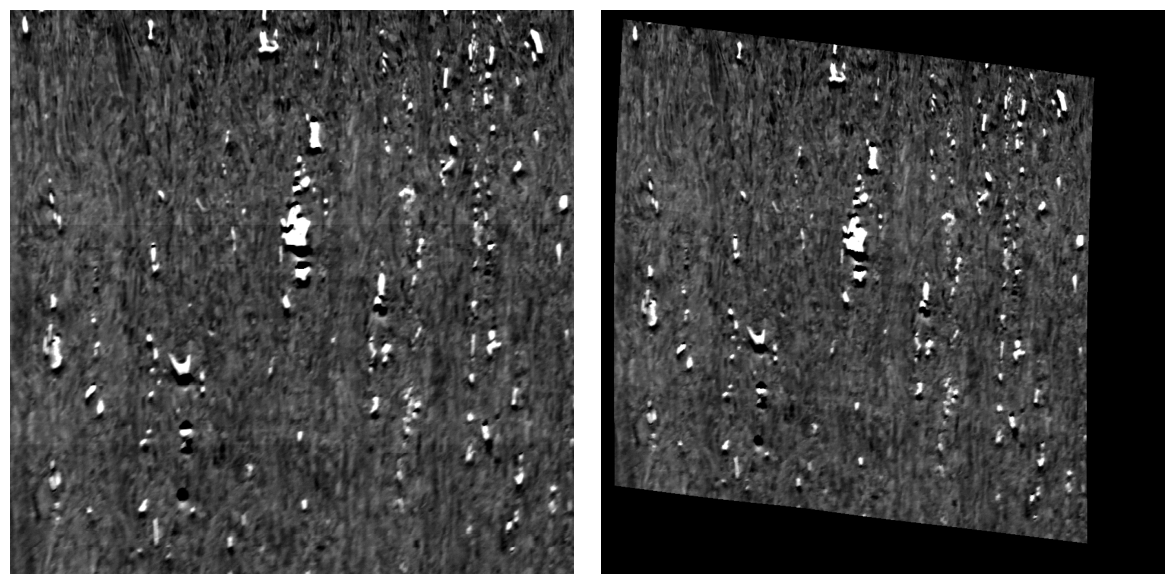

In [28]:
ebsd_correct = map_in_image(ebsd, out_shape, rc_in_2d, rc_out_2d)

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].imshow(ebsd, cmap="gray")
ax[1].imshow(ebsd_correct, cmap="gray")
for a in ax:
    a.axis("off")
fig.tight_layout()

In [29]:
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True

plt.imsave(os.path.join(dir_imreg, "ebsd_correct.png"), ebsd_correct, cmap="gray")
np.save(os.path.join(dir_imreg, "mask_ebsd_correct"), mask)

Check overlap of EBSD map and BSE image

In [30]:
# Rescale mask and apply to rescaled EBSD intensity map
mask2 = skt.rescale(mask, scale_ebsd_bse).astype(bool)
ebsd_correct2 = skt.rescale(ebsd_correct, scale_ebsd_bse)

# Pad BSE image or crop mask and EBSD ROI, depending on which have the greater
# shape
mask2_bse_shape_diff = np.array(mask2.shape) - np.array(bse.shape)
if mask2_bse_shape_diff[0] > 0:
    # Add rows to the end of the BSE image
    bse2 = np.pad(bse, [(0, mask2_bse_shape_diff[0]), (0, 0)])
    ebsd_correct3 = ebsd_correct2.copy()
else:
    # Add rows to the end of the rescaled mask and EBSD intensity map
    mask2 = mask2[:bse.shape[0]]
    ebsd_correct3 = ebsd_correct2[:bse.shape[0]]
    mask2 = np.pad(mask2, [(0, -mask2_bse_shape_diff[0]), (0, 0)])
    ebsd_correct3 = np.pad(ebsd_correct3, [(0, -mask2_bse_shape_diff[0]), (0, 0)])
    bse2 = bse.copy()
if mask2_bse_shape_diff[1] > 0:
    # Add columns to the end of the BSE image
    bse2 = np.pad(bse2, [(0, 0), (0, mask2_bse_shape_diff[1])])
else:
    # Add columns to the end of the rescaled mask and EBSD intensity map
    mask2 = mask2[:, :bse.shape[1]]
    ebsd_correct3 = ebsd_correct3[:, :bse.shape[1]]
    mask2 = np.pad(mask2, [(0, 0), (0, -mask2_bse_shape_diff[1])])
    ebsd_correct3 = np.pad(ebsd_correct3, [(0, 0), (0, -mask2_bse_shape_diff[1])])

# Apply mask to BSE image
bse2[~mask2] = 0

# Rescale intensities
ebsd_correct4 = ske.rescale_intensity(ebsd_correct3, out_range=(0, 1))
bse3 = ske.rescale_intensity(bse2, out_range=(0, 1))
reg_im = np.stack((ebsd_correct4, bse3, ebsd_correct4), axis=2)

Check overlap of corrected EBSD map and BSE image

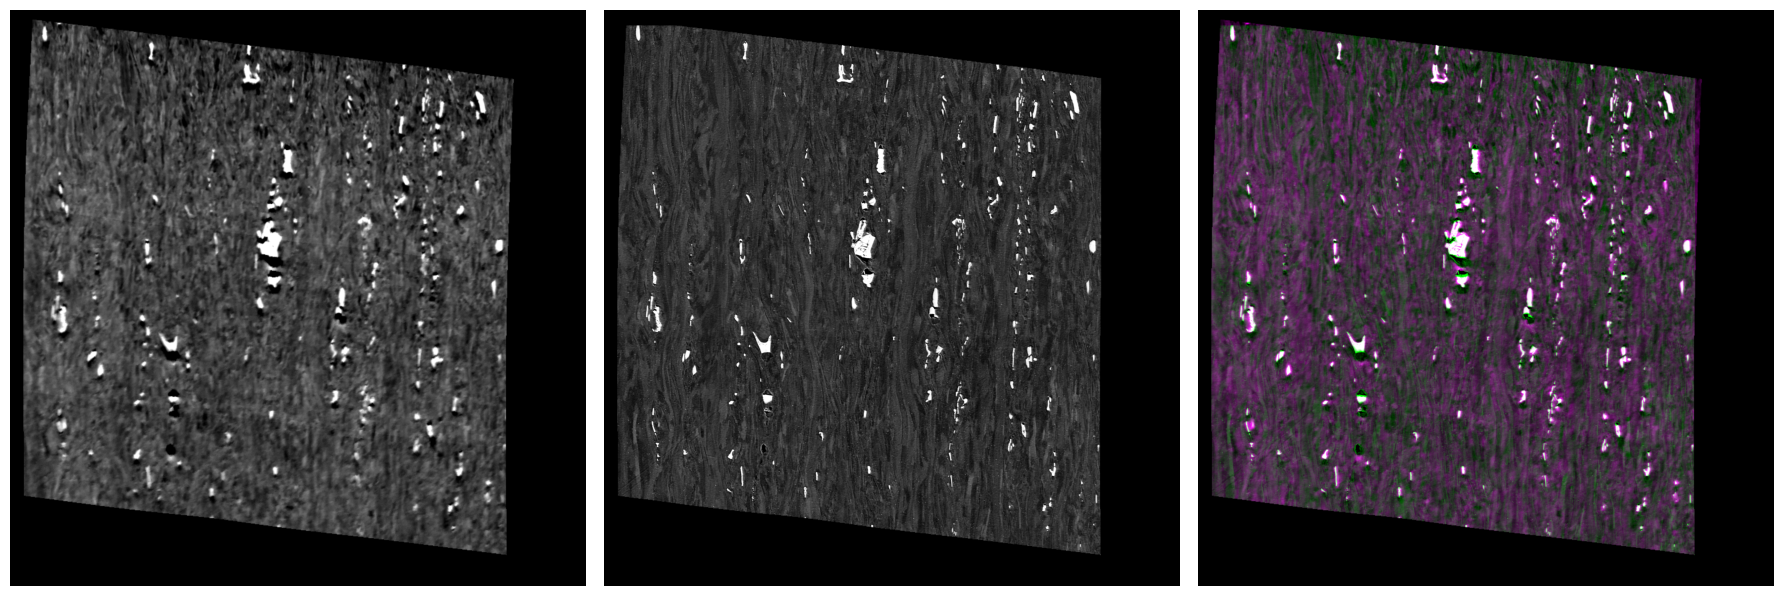

In [31]:
fig, ax = plt.subplots(figsize=(18, 12), ncols=3, sharex=True, sharey=True)
ax[0].imshow(ebsd_correct4, cmap="gray")
ax[1].imshow(bse3, cmap="gray")
ax[2].imshow(reg_im)
for a in ax:
    a.axis("off")
fig.tight_layout()

Save images

In [32]:
# With padding
plt.imsave(os.path.join(dir_imreg, "reg_ebsd.png"), ebsd_correct4, cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_bse.png"), bse3, cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_rgb.png"), reg_im)

In [33]:
# Without padding
rc_out_2d_scaled = np.column_stack(rc_out_2d) * scale_ebsd_bse
r_start, c_start = np.floor(rc_out_2d_scaled.min(axis=0)).astype(int)
r_end, c_end = np.ceil(rc_out_2d_scaled.max(axis=0)).astype(int)
sl = (slice(r_start, r_end), slice(c_start, c_end))

plt.imsave(os.path.join(dir_imreg, "reg_ebsd_no_padding.png"), ebsd_correct4[sl], cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_bse_no_padding.png"), bse3[sl], cmap="gray")
plt.imsave(os.path.join(dir_imreg, "reg_rgb_no_padding.png"), reg_im[sl])

## 3. Load particle map

Particles are detected with *ImageJ* following the procedure detailed in the notebook `bse2_particle_detection.ipynb`.

Load binary particle map

In [34]:
labels = np.load(os.path.join(dir_partdet, "bse_labels_filled_filtered_roi.npy"))

## 4. Bin particle map

Slice binary particle map to enable integer binning

In [35]:
row_labels, col_labels = labels.shape
row_new = row_labels - (row_labels % x_bin)
col_new = col_labels - (col_labels % x_bin)
labels2 = labels[:row_new, :col_new]

Separate the map into blocks of equal size, e.g. (4, 4), which are binned using
a custom function

In [36]:
view = sku.view_as_blocks(labels2, block_shape=(x_bin, x_bin))

Bin by counting the number of particles within each block and the number of
unbinned pixels that are particles. This property is important because within
each block of size (4, 4), a particle of one pixel and 16 pixels must of course
be assigned different sizes in the final analysis.

In [37]:
def count_particles(block):
    unique_labels, unique_counts = np.unique(block, return_counts=True)
    particle_labels = unique_labels > 0
    return np.count_nonzero(particle_labels), unique_counts[particle_labels]


n_particles = np.zeros(view.shape[:2], dtype=int)
n_pixels_list = np.zeros(view.shape[:2], dtype=object)
for idx in tqdm(np.ndindex(view.shape[:-2]), total=np.prod(view.shape[:2])):
    n_particles_i, n_pixels_i = count_particles(view[idx])
    n_particles[idx] = n_particles_i
    n_pixels_list[idx] = n_pixels_i

100%|█████████████████████████████████████████████████████████| 761780/761780 [00:16<00:00, 47276.63it/s]


Calculate number of particle pixels within each binned pixel

In [38]:
particle_mask = n_particles != 0
n_pixels = np.zeros(n_particles.shape, dtype=float)
for r, c in zip(*np.where(particle_mask)):
    n_pixels[r, c] = n_pixels_list[r, c].sum()

Make particle map of equal size to new EBSD data

In [39]:
n_particles_roi = np.zeros(out_shape, dtype=int)
n_pixels_roi = np.zeros(out_shape)
dr, dc = np.array(n_particles.shape) - np.array(out_shape)
if dr > 0:
    pad_r = [(0, dr), (0, 0)]
    n_particles_roi = np.pad(n_particles_roi, pad_r)
    n_pixels_roi = np.pad(n_pixels_roi, pad_r)
if dc > 0:
    pad_c = [(0, 0), (0, dc)]
    n_particles_roi = np.pad(n_particles_roi, pad_c)
    n_pixels_roi = np.pad(n_pixels_roi, pad_c)

nr_part, nc_part = n_particles.shape
n_particles_roi[:nr_part, :nc_part] = n_particles
n_pixels_roi[:nr_part, :nc_part] = n_pixels

# Mask to ROI only
mask = np.zeros(out_shape, dtype=bool)
mask[rc_out_2d] = True
n_particles_roi = n_particles_roi[:out_shape[0], :out_shape[1]]
n_pixels_roi = n_pixels_roi[:out_shape[0], :out_shape[1]]
n_particles_roi[~mask] = 0
n_pixels_roi[~mask] = 0

Check overlap

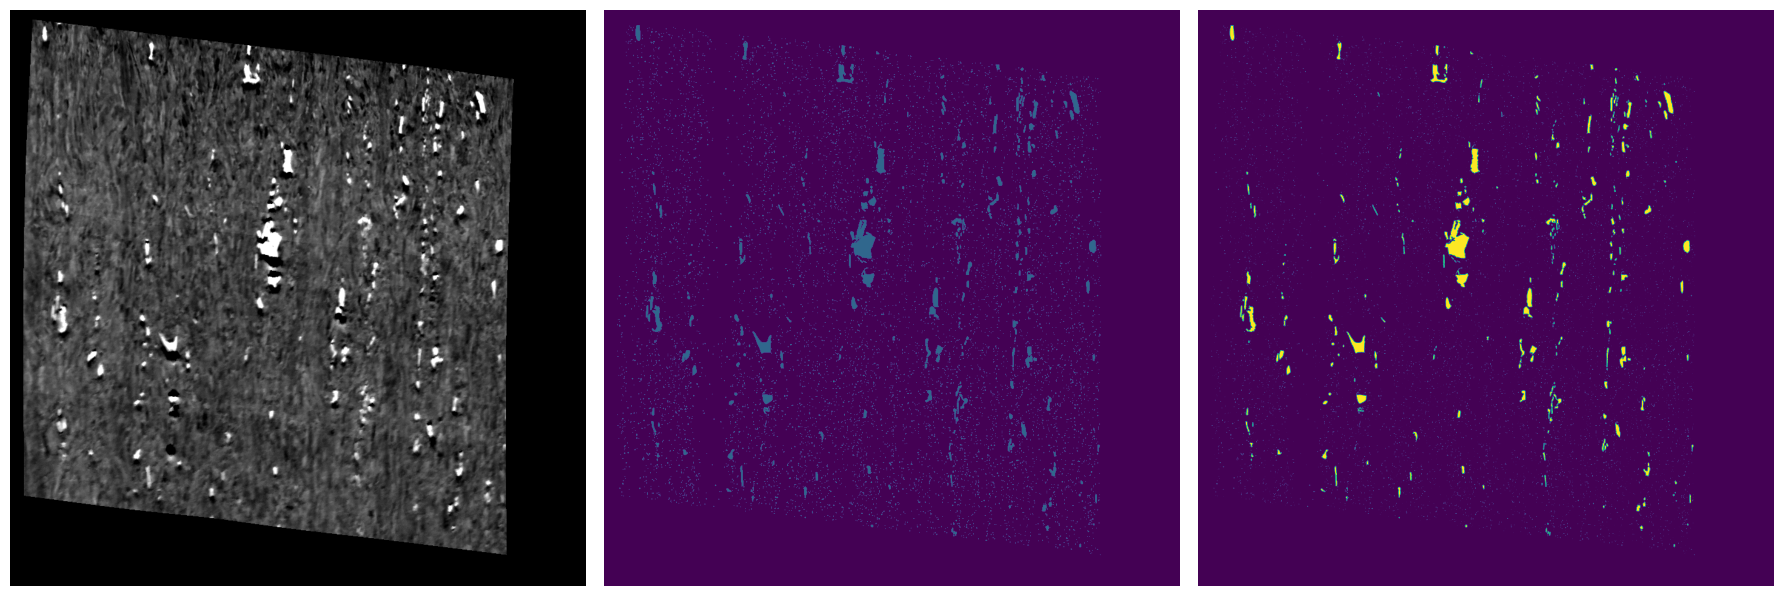

In [40]:
fig, ax = plt.subplots(figsize=(18, 12), ncols=3, sharex=True, sharey=True)
ax[0].imshow(ebsd_correct, cmap="gray")
ax[1].imshow(n_particles_roi)
ax[2].imshow(n_pixels_roi)
for a in ax:
    a.axis("off")
fig.tight_layout()

Save to file

In [41]:
np.save(os.path.join(dir_imreg, "n_particles"), n_particles)
np.save(os.path.join(dir_imreg, "n_particles_roi"), n_particles_roi)
np.save(os.path.join(dir_imreg, "n_pixels_roi"), n_pixels_roi)

## 5. Create new crystal map with corrected coordinates and particle locations

(Ignore a possible `VisibleDeprecationWarning`.)

In [42]:
xmap_refori = oio.load(os.path.join(dir_kp, "xmap_refori.h5"))
xmap_refori.scan_unit = "um"

/home/hakon/miniconda3/envs/p-dev/lib/python3.10/site-packages/orix/crystal_map/crystal_map.py:221: VisibleDeprecationWarning: Argument `z` is deprecated and will be removed in version 0.11.0. To avoid this warning, please do not use `z`. See the documentation of `__init__()` for more details.
  def __init__(


Get BSE ROI to insert into crystal map

In [43]:
# Rescale
bse_roi = skt.rescale(bse, step_size["bse"] / step_size["ebsd"])

# Pad
dr, dc = np.array(out_shape) - np.array(bse_roi.shape)
if dr > 0:
    bse_roi = np.pad(bse_roi, [(0, dr), (0, 0)])
else:
    bse_roi = bse_roi[:out_shape[0]]
if dc > 0:
    bse_roi = np.pad(bse_roi, [(0, 0), (0, dc)])
else:
    bse_roi = bse_roi[:, :out_shape[1]]

# Mask
bse_roi[~mask] = 0

Map EBSD orientations, phase IDs etc.

In [44]:
# Rotations
rot_out = Rotation.identity((out_size,))
rot_out[rc_out_1d] = xmap_refori._rotations[rc_in_1d]

# Phase ID
phase_id_out = -np.ones(out_size, dtype=int)
phase_id_out[rc_out_1d] = xmap_refori._phase_id[rc_in_1d]

# Spatial coordinates
y_out, x_out = rc_out.T * xmap_refori.dx

# Current properties
prop_out = {}
for k, v in xmap_refori.prop.items():
    prop = np.full(out_size, fill_value=0, dtype=v.dtype)
    prop[rc_out_1d] = v[rc_in_1d]
    prop_out[k] = prop

# New properties
r_shift, c_shift = rc_shift.T
prop_out["r_shift"] = r_shift
prop_out["c_shift"] = c_shift
prop_out["n_particles"] = n_particles_roi.ravel()
prop_out["bse"] = bse_roi.ravel()
prop_out["n_pixels"] = n_pixels_roi.ravel()

# Is in data mask
is_in_data_out = np.zeros(out_size, dtype=bool)
is_in_data_out[rc_out_1d] = True

# Get new crystal map
xmap_refori2 = CrystalMap(
    rotations=rot_out,
    phase_id=phase_id_out,
    phase_list=xmap_refori.phases,
    x=x_out,
    y=y_out,
    prop=prop_out,
    scan_unit=xmap_refori.scan_unit,
    is_in_data=is_in_data_out,
)

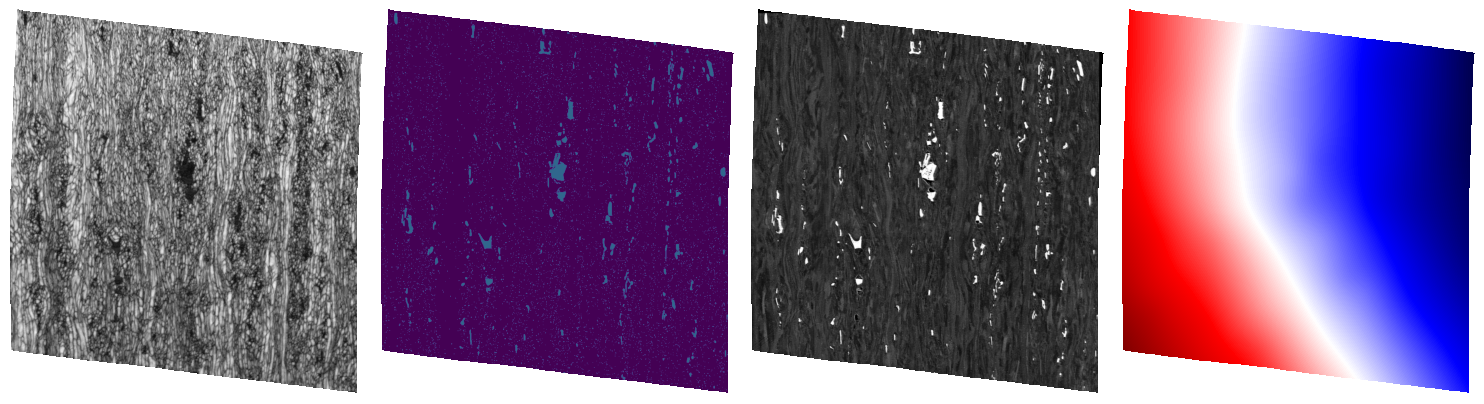

In [45]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(15, 5))
ax[0].imshow(xmap_refori2.get_map_data("scores"), cmap="gray")
ax[1].imshow(xmap_refori2.get_map_data("n_particles"))
ax[2].imshow(xmap_refori2.get_map_data("bse"), cmap="gray")
ax[3].imshow(xmap_refori2.get_map_data("r_shift"), cmap="seismic")
for a in ax:
    a.axis("off")
fig.tight_layout();

In [46]:
oio.save(os.path.join(dir_kp, "xmap_refori2.h5"), xmap_refori2, overwrite=True)
oio.save(
    os.path.join(dir_kp, "xmap_refori2.ang"),
    xmap_refori2,
    extra_prop=["n_particles", "n_pixels"],
    overwrite=True
)

Compare map areas before and after correction

In [47]:
# Shape of ROI
nominal_shape = np.array(xmap_refori.shape) * xmap_refori.dx
actual_shape = (
    xmap_refori2.y.max() - xmap_refori2.y.min(),
    xmap_refori2.x.max() - xmap_refori2.x.min()
)
print(
    "ROI\n---",
    "\nNominal (square):\t", np.round(nominal_shape, decimals=1), "um^2",
    "\nActual (non-square):\t", np.round(actual_shape, decimals=1), "um^2"
)

# Total area of scanned points
nominal_area = xmap_refori.size * xmap_refori.dx ** 2
actual_area = xmap_refori2.size * xmap_refori2.dx ** 2
print(
    "\nArea\n----",
    f"\nNominal:\t\t {nominal_area:.2f} um^2",
    f"\nActual:\t\t\t {actual_area:.2f} um^2",
    f"\nActual / nominal:\t {100 * actual_area / nominal_area:.1f}%",
)

ROI
--- 
Nominal (square):	 [81.9 81.9] um^2 
Actual (non-square):	 [88.2 80.8] um^2

Area
---- 
Nominal:		 6707.61 um^2 
Actual:			 6269.43 um^2 
Actual / nominal:	 93.5%
